# CORE: INDIVIDUAL PROJECT
## AIM: DEVELOP A STAFFING PROMOTION ALGORITHM

## Defining the Learning Objective

    a) Specifying the Data Analytics Question
   > To predict the important features that can be used to predict promotion eligibility.

## Importing Libraries

In [3]:
# Basic Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as mnso
import pandas_profiling
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Spliting
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import model_selection

# Sampling  
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

# Machine Learning
from sklearn import svm  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn import metrics
from collections import Counter
from sklearn.svm import LinearSVC, SVC, SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import graphviz

# roc curve and auc score
from sklearn.metrics import roc_curve, roc_auc_score, auc

Using TensorFlow backend.


### Loading the Data

In [4]:
Main_Data = pd.read_csv('data.csv')
Main_Data.head()

EmployeeNo                               Division        Qualification  \
0  YAK/S/00001         Commercial Sales and Marketing     MSc, MBA and PhD   
1  YAK/S/00002  Customer Support and Field Operations  First Degree or HND   
2  YAK/S/00003         Commercial Sales and Marketing  First Degree or HND   
3  YAK/S/00004         Commercial Sales and Marketing  First Degree or HND   
4  YAK/S/00006               Information and Strategy  First Degree or HND   

   Gender   Channel_of_Recruitment  Trainings_Attended  Year_of_birth  \
0  Female  Direct Internal process                   2           1986   
1    Male        Agency and others                   2           1991   
2    Male  Direct Internal process                   2           1987   
3    Male        Agency and others                   3           1982   
4    Male  Direct Internal process                   3           1990   

   Last_performance_score  Year_of_recruitment  Targets_met  Previous_Award  \
0                    12.5                 2011            1               0   
1                    12.5                 2015            0               0   
2                     7.5                 2012            0               0   
3                     2.5                 2009            0               0   
4                     7.5                 2012            0               0   

   Training_score_average Foreign_schooled Past_Disciplinary_Action  \
0                      41               No                       No   
1                      52              Yes                       No   
2                      42              Yes                       No   
3                      42              Yes                       No   
4                      77              Yes                       No   

  Previous_IntraDepartmental_Movement No_of_previous_employers  \
0                                  No                        0   
1                                  No                        0   
2                                  No                        0   
3                                  No                        1   
4                                  No                        1   

   Promoted_or_Not  
0                0  
1                0  
2                0  
3                0  
4                0

In [3]:
Data_Prof_Main_Data = Main_Data.profile_report(title ='Pandas Profiling Report', plot={'histogram': {'bins': 8}})
rejected_variables = Data_Prof_Main_Data.get_rejected_variables(threshold=0.9)
Data_Prof_Main_Data

In [4]:
import plotly
plotly.offline.init_notebook_mode(connected=False)
import plotly.graph_objs as go

# Print the total number of unique Performance of Employee
num_unique = len(Main_Data['Last_performance_score'].unique())
print('Number of Unique_Values = ', num_unique)

# Count the Performance of each Employee and sort them in descending order
Perform=Main_Data['Last_performance_score'].value_counts().sort_values(ascending=False)
print(Perform)
data = [go.Bar(
        x = Perform.index, # index = Employee ID
        y = Perform.values, # value = count
)]

plotly.offline.iplot(data)
plt.show()

Number of Unique_Values =  6
7.5     12993
12.5     8213
10.0     6932
2.5      4325
5.0      2944
0.0      2905
Name: Last_performance_score, dtype: int64


### Preparing a comprehensive exploratory data analysis (EDA)

* The Summary of a DataFrame helps to understand the type of variable, data type and presence of null values.

In [5]:
# The size of Data set
print('The size of the Train_Riders data is :', Main_Data.size)

# Show dimension of the data
print("Dimension: {}".format(Main_Data.shape))

The size of the Train_Riders data is : 651304
Dimension: (38312, 17)


* The size of Main_Data is 651304 which is made up of the number of rows times the number of columns of the DataFrame.
* The Main_Data comprises of 38312 observations and 17 features,
* out of which one is dependent variable (Target - Promoted_or_Not) and the remaining 18 are independent variables.

In [6]:
print(Main_Data.columns.values)

['EmployeeNo' 'Division' 'Qualification' 'Gender' 'Channel_of_Recruitment'
 'Trainings_Attended' 'Year_of_birth' 'Last_performance_score'
 'Year_of_recruitment' 'Targets_met' 'Previous_Award'
 'Training_score_average' 'Foreign_schooled' 'Past_Disciplinary_Action'
 'Previous_IntraDepartmental_Movement' 'No_of_previous_employers'
 'Promoted_or_Not']


- Lable of each column of the Dataset

In [7]:
print(Main_Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38312 entries, 0 to 38311
Data columns (total 17 columns):
EmployeeNo                             38312 non-null object
Division                               38312 non-null object
Qualification                          36633 non-null object
Gender                                 38312 non-null object
Channel_of_Recruitment                 38312 non-null object
Trainings_Attended                     38312 non-null int64
Year_of_birth                          38312 non-null int64
Last_performance_score                 38312 non-null float64
Year_of_recruitment                    38312 non-null int64
Targets_met                            38312 non-null int64
Previous_Award                         38312 non-null int64
Training_score_average                 38312 non-null int64
Foreign_schooled                       38312 non-null object
Past_Disciplinary_Action               38312 non-null object
Previous_IntraDepartmental_Movement    383

* The Data have float64, object and integer values
* In the dataset, Qualification column have null/missing values

## Summary Statistics

In [8]:
Target_Column = ['Promoted_or_Not']
Predictors = list(set(list(Main_Data.columns))-set(Target_Column))
Numeric_Data = Main_Data._get_numeric_data()
Stat_of_Main_Data = Numeric_Data.describe(include='all')
Stat_of_Main_Data = Stat_of_Main_Data.transpose()
Stat_of_Main_Data.to_csv('Descriptive_Statistics_of_Data.csv', index=False)
Stat_of_Main_Data

count         mean        std     min     25%  \
Trainings_Attended      38312.0     2.253680   0.609443     2.0     2.0   
Year_of_birth           38312.0  1986.209334   7.646047  1950.0  1982.0   
Last_performance_score  38312.0     7.698959   3.744135     0.0     5.0   
Year_of_recruitment     38312.0  2013.139695   4.261451  1982.0  2012.0   
Targets_met             38312.0     0.352996   0.477908     0.0     0.0   
Previous_Award          38312.0     0.023152   0.150388     0.0     0.0   
Training_score_average  38312.0    55.366465  13.362741    31.0    43.0   
Promoted_or_Not         38312.0     0.084595   0.278282     0.0     0.0   

                           50%     75%     max  
Trainings_Attended         2.0     2.0    11.0  
Year_of_birth           1988.0  1992.0  2001.0  
Last_performance_score     7.5    10.0    12.5  
Year_of_recruitment     2014.0  2016.0  2018.0  
Targets_met                0.0     1.0     1.0  
Previous_Award             0.0     0.0     1.0  
Training_score_average    52.0    68.0    91.0  
Promoted_or_Not            0.0     0.0     1.0

## Key Observations -

* Mean value is greater than the median value of each column represented by 50%(50th percentile) in the row
* Notably, there is a large differnece in 75th percentile and Max values of predictors "Trainings_Attended", "Year_of_birth", "Year_of_recruitment" and "Training_score_average" but the remaining predictors have small (or equal) difference in the 75th percentile and Max values 
* Thus, observations 1 and 2 suggests that there are extreme values/Outliers in some part of our dataset. *We confirmed this by using boxplot as it is better visualisation for outliers* 

## To Check for Outliers

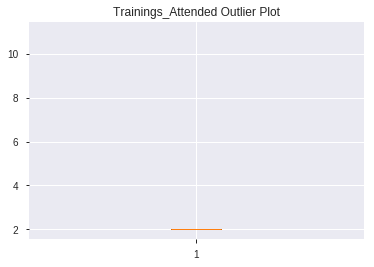

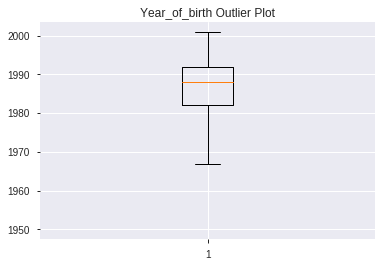

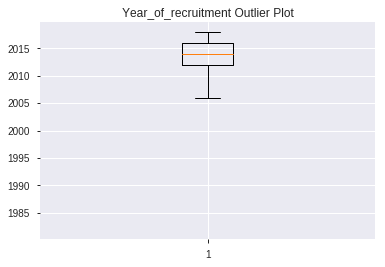

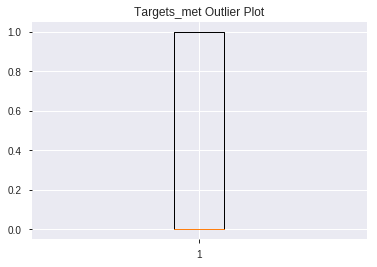

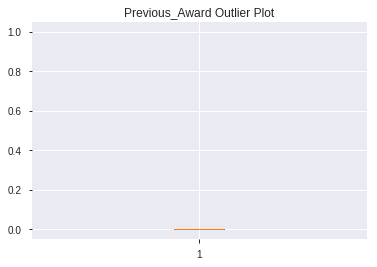

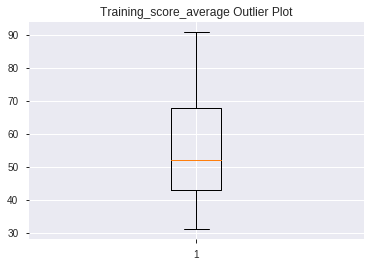

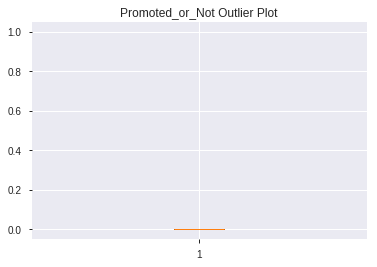

In [9]:
def Detecting_Outliers(Data):
    
    threshold=1
    mean = np.mean(Data) # computing mean of the dataset
    std =np.std(Data)  # computing the standard deviation
    
    for y in Data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > threshold:
            Outliers.append(y)        
    return Outliers

fig=plt.figure()

for i  in range(0,len(Main_Data.columns)):
    Outliers=[]
   
    if Main_Data[Main_Data.columns[i]].dtypes== np.int64 or Main_Data[Main_Data.columns[i]].dtypes== np.int64  :
        
        Outliers=Detecting_Outliers(Main_Data.iloc[:,i])
        if len(Outliers)>0:
                   
            ax = plt.subplot(1,1,1)
            #Variable
            ax.boxplot(Main_Data[list(Main_Data.columns)[i]])
            plt.title(list(Main_Data.columns)[i] + " Outlier Plot")
            plt.show()

* The Numerical (int64) features with the Black dots either above or below the whisk are all having outliers
* Outliers are performed on Numerical Variables of the Dataset

In [10]:
# Numeric Data
Numeric_Data = Main_Data._get_numeric_data()
Numeric_Data.head(3)

Trainings_Attended  Year_of_birth  Last_performance_score  \
0                   2           1986                    12.5   
1                   2           1991                    12.5   
2                   2           1987                     7.5   

   Year_of_recruitment  Targets_met  Previous_Award  Training_score_average  \
0                 2011            1               0                      41   
1                 2015            0               0                      52   
2                 2012            0               0                      42   

   Promoted_or_Not  
0                0  
1                0  
2                0

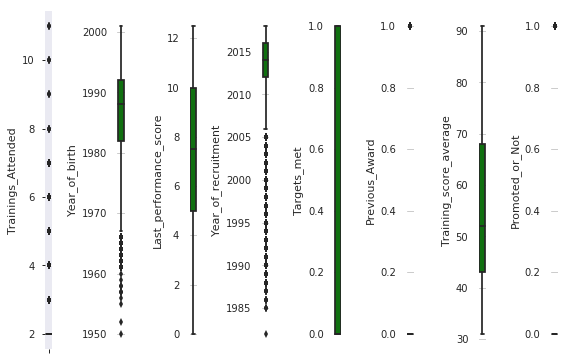

In [10]:
lent = Numeric_Data.columns.values
number_of_columns = 8
number_of_rows = len(lent)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(lent)):
    plt.subplot(number_of_rows + 1, number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(Numeric_Data[lent[i]],color='green',orient='v')
    plt.tight_layout()

## Performing KDE

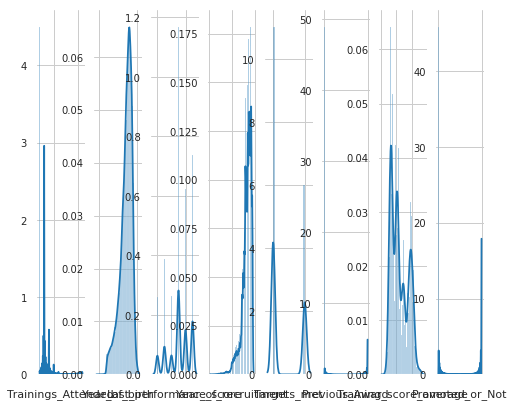

In [11]:
plt.figure(figsize=(number_of_columns, 8*number_of_rows))
for i in range(0,len(lent)):
    plt.subplot(number_of_rows + 1, number_of_columns,i+1)
    chart=sns.distplot(Numeric_Data[lent[i]], kde=True) 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=None, 
                          horizontalalignment='right')
plt.show()

## Univariate Analysis

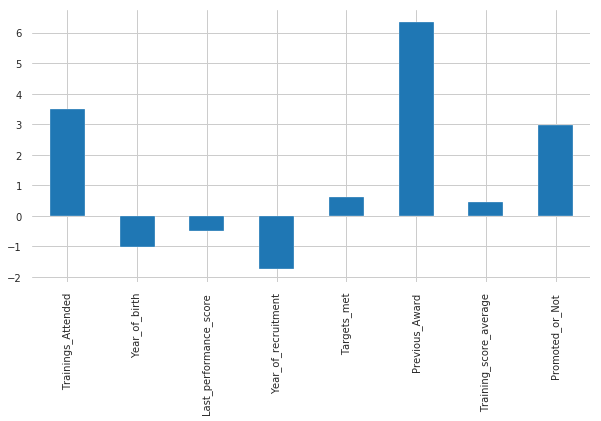

In [12]:
# Calculating Skewness in the columns of our Numeric dataset

Numeric_Data.skew().plot.bar(figsize =(10,5))
plt.show()

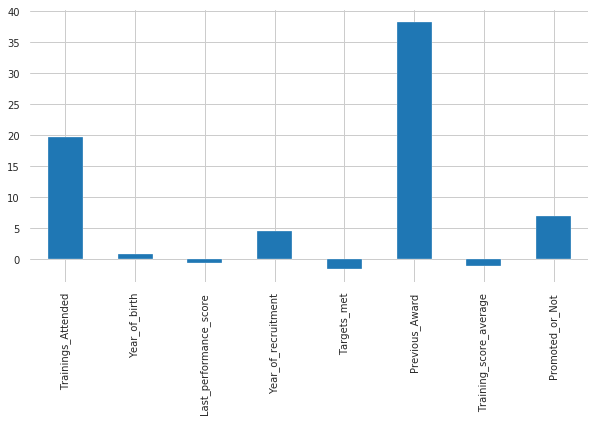

In [13]:
# Measuring Kurtosis in our Numeric dataset

Numeric_Data.kurt().plot.bar(figsize =(10,5))
plt.show()

## Understanding the Target Variable

In [14]:
Main_Data['Promoted_or_Not'].unique()

array([0, 1])

* Target variable/Dependent variable is dummy variable in nature. 
* If the Employee is Promoted, it is a 1 and if Not, it is a 0.

In [15]:
Main_Data['Promoted_or_Not'].value_counts(sort=True)

0    35071
1     3241
Name: Promoted_or_Not, dtype: int64

* This tells us the vote count of whether employees are promoted or not in descending order.
* Promoted_or_Not has most values concentrated on _Not Promoted_
* Few employees are mostly Promoted. $\textbf{Therefore, we can infer that the data is imbalanced}$

## Visualising the Dataset
### Checking for Missing Values in the Data

## Missing Values

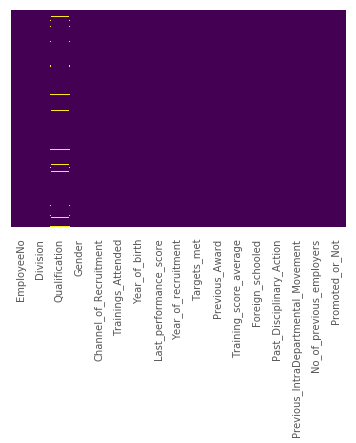

In [16]:
import matplotlib.style as style
style.use('ggplot')
sns.heatmap(Main_Data.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

* The Dataset has missing values in the _"Qualification"_ Variable
* The missing values are noticed in figure (above) represented by yellow colour shade on the purple background.

In [17]:
def percent_missing(Main_Data):
    return Main_Data.isnull().sum()/Main_Data.isnull().count()

In [18]:
# Total number and Percentage of missing values in the dataset

missing_table = pd.concat([Main_Data.isnull().sum(),percent_missing(Main_Data)], axis=1, 
                         keys=['Total_Missing', 'Percent_Missing'], sort = False)
missing_table.to_csv('missing.csv',index=True)

missing_table.head(3)

Total_Missing  Percent_Missing
EmployeeNo                 0         0.000000
Division                   0         0.000000
Qualification           1679         0.043824

In [19]:
missing_table2 = missing_table[missing_table.Total_Missing!=0]

# Save to CSV file
#missing_table2.to_csv('missing_Specific.csv',index=True)

# print
missing_table2

Total_Missing  Percent_Missing
Qualification           1679         0.043824

* The Data has total percent missing cells of  0.3% (from the Pandas_Profiling above)
* The percentage of missing values in the Qualification variable is 4.38%

## Checking for Correlation

### Correlation Matrix

In [20]:
Corr_Matrix = Main_Data.corr()
Corr_Matrix

Trainings_Attended  Year_of_birth  \
Trainings_Attended                1.000000       0.078710   
Year_of_birth                     0.078710       1.000000   
Last_performance_score           -0.062042      -0.175572   
Year_of_recruitment               0.056215       0.654666   
Targets_met                      -0.044789       0.025337   
Previous_Award                   -0.007409       0.013627   
Training_score_average            0.041065       0.048390   
Promoted_or_Not                  -0.024345       0.017991   

                        Last_performance_score  Year_of_recruitment  \
Trainings_Attended                   -0.062042             0.056215   
Year_of_birth                        -0.175572             0.654666   
Last_performance_score                1.000000            -0.190333   
Year_of_recruitment                  -0.190333             1.000000   
Targets_met                           0.276350             0.076910   
Previous_Award                        0.026587             0.041995   
Training_score_average                0.057836             0.037477   
Promoted_or_Not                       0.119690             0.012287   

                        Targets_met  Previous_Award  Training_score_average  \
Trainings_Attended        -0.044789       -0.007409                0.041065   
Year_of_birth              0.025337        0.013627                0.048390   
Last_performance_score     0.276350        0.026587                0.057836   
Year_of_recruitment        0.076910        0.041995                0.037477   
Targets_met                1.000000        0.092934                0.077201   
Previous_Award             0.092934        1.000000                0.072360   
Training_score_average     0.077201        0.072360                1.000000   
Promoted_or_Not            0.224518        0.201434                0.178448   

                        Promoted_or_Not  
Trainings_Attended            -0.024345  
Year_of_birth                  0.017991  
Last_performance_score         0.119690  
Year_of_recruitment            0.012287  
Targets_met                    0.224518  
Previous_Award                 0.201434  
Training_score_average         0.178448  
Promoted_or_Not                1.000000

* From the Correlation Matrix above, we see that the _"Trainings_Attended"_ variable has high correlation with the other variables but not a basis to conclude that it is an important feature or not.
* The _"Previous_Award"_ variable has very low correlation with the remaining variables and can infer that it is neglible. However, the correlation matrix is not a basis to drop or remove feature as it can be deceicing. 

#### A seaborn heatmap to better show the correlation matrix

Text(0.5, 1.0, 'Heatmap')

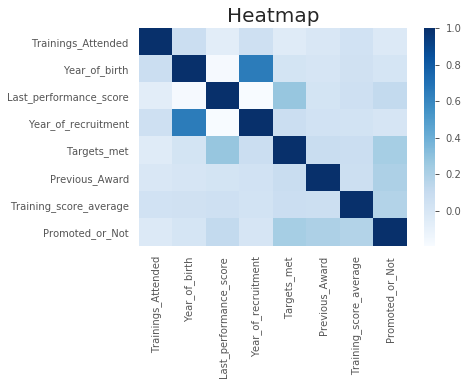

In [21]:
import matplotlib.style as style
style.use('ggplot')

plt.subplots() #(figsize=(6,4))
sns.heatmap(Corr_Matrix,cmap='Blues',annot=False) 
plt.title('Heatmap', fontsize=20)

* Dark shades in the Dataset represents positive correlation while lighter shades represents negative correlation and the faded represents No or weak correlation.
* If we set annot=True, you'll get values by which features are correlated to each other in grid-cells. The code is implemented below

Text(0.5, 1.0, 'Pearson Correlation of Features')

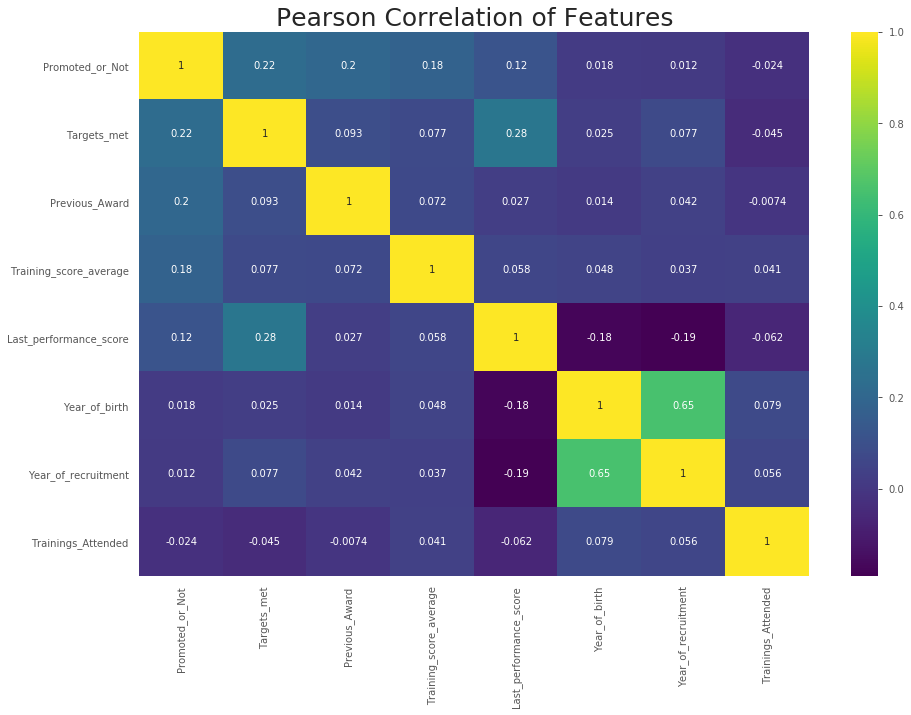

In [22]:
import matplotlib.style as style
style.use('ggplot')

k = 17  # number of variables of Data for heatmap
cols = Corr_Matrix.nlargest(k, 'Promoted_or_Not')['Promoted_or_Not'].index
cm = Main_Data[cols].corr()
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, cmap = 'viridis')
plt.title('Pearson Correlation of Features', fontsize=25)

### Creating a copy of the Main Data

In [23]:
New_Data = Main_Data.copy()

In [24]:
Main_Data.columns

Index(['EmployeeNo', 'Division', 'Qualification', 'Gender',
       'Channel_of_Recruitment', 'Trainings_Attended', 'Year_of_birth',
       'Last_performance_score', 'Year_of_recruitment', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'Foreign_schooled',
       'Past_Disciplinary_Action', 'Previous_IntraDepartmental_Movement',
       'No_of_previous_employers', 'Promoted_or_Not'],
      dtype='object')

## Dealing with Missing Values

In [25]:
New_Data['Qualification'].fillna('First Degree or HND', inplace=True)
New_Data.Qualification.head(10)

0       MSc, MBA and PhD
1    First Degree or HND
2    First Degree or HND
3    First Degree or HND
4    First Degree or HND
5    First Degree or HND
6       MSc, MBA and PhD
7    First Degree or HND
8       MSc, MBA and PhD
9    First Degree or HND
Name: Qualification, dtype: object

* We filled all NaN's with the mode of the Qualification Variable, with which we can infer that the company employs people with First Degree or HND

In [26]:
Missing = New_Data.isnull().sum()
Missing

EmployeeNo                             0
Division                               0
Qualification                          0
Gender                                 0
Channel_of_Recruitment                 0
Trainings_Attended                     0
Year_of_birth                          0
Last_performance_score                 0
Year_of_recruitment                    0
Targets_met                            0
Previous_Award                         0
Training_score_average                 0
Foreign_schooled                       0
Past_Disciplinary_Action               0
Previous_IntraDepartmental_Movement    0
No_of_previous_employers               0
Promoted_or_Not                        0
dtype: int64

In [27]:
# Saving the cleaned datasets
#New_Data.to_csv('Data_cleaned.csv')

# Feature Engineering

### Converting Year_of_Birth into Age of the Employee

In [28]:
print(New_Data['Year_of_birth'].min())
New_Data['Year_of_birth'].max()

1950


2001

In [29]:
New_Data['Year_of_birth'].head()

0    1986
1    1991
2    1987
3    1982
4    1990
Name: Year_of_birth, dtype: int64

In [30]:
Age = []
Current_year = 2019 # We suppose the Decision will be made in the current year
for year in New_Data['Year_of_birth']:
    years = Current_year - year
    Age.append(years)

In [31]:
New_Data['Age_of_Employee'] = Age

In [32]:
New_Data['Age_of_Employee'].head(3)

0    33
1    28
2    32
Name: Age_of_Employee, dtype: int64

In [33]:
New_Data.head(2)

EmployeeNo                               Division        Qualification  \
0  YAK/S/00001         Commercial Sales and Marketing     MSc, MBA and PhD   
1  YAK/S/00002  Customer Support and Field Operations  First Degree or HND   

   Gender   Channel_of_Recruitment  Trainings_Attended  Year_of_birth  \
0  Female  Direct Internal process                   2           1986   
1    Male        Agency and others                   2           1991   

   Last_performance_score  Year_of_recruitment  Targets_met  Previous_Award  \
0                    12.5                 2011            1               0   
1                    12.5                 2015            0               0   

   Training_score_average Foreign_schooled Past_Disciplinary_Action  \
0                      41               No                       No   
1                      52              Yes                       No   

  Previous_IntraDepartmental_Movement No_of_previous_employers  \
0                                  No                        0   
1                                  No                        0   

   Promoted_or_Not  Age_of_Employee  
0                0               33  
1                0               28

### Converting "Year_of_Recruitment" into "Number_of_Years_Worked"

In [34]:
Number_years = []
Current_year = 2019 # We suppose the Decision will be made in the current year
for year in New_Data['Year_of_recruitment']:
    years = Current_year - year
    Number_years.append(years)

In [35]:
New_Data['Number_of_Years_Worked'] = Number_years

In [36]:
New_Data['Number_of_Years_Worked'].head(5)

0     8
1     4
2     7
3    10
4     7
Name: Number_of_Years_Worked, dtype: int64

### Creating a Feature for Employee starting his/her career with the Organisation

In [37]:
'''
If the No of previous employers is counted to be 0, then we consider the 
Employee to start his/her career with the organisation with "YES".
Otherwise, "NO".
''' 
New_Data['Started_work_at_the_company']=np.where(New_Data['No_of_previous_employers']=='0',
                                                 'Yes','No')

In [38]:
New_Data[["Started_work_at_the_company", 'No_of_previous_employers']].head(5)

Started_work_at_the_company No_of_previous_employers
0                         Yes                        0
1                         Yes                        0
2                         Yes                        0
3                          No                        1
4                          No                        1

### Creating a feature using the last performance score and his/her Targets met

In [39]:
print(np.round(New_Data['Last_performance_score'].mean(), 0)) # to the nearest whole number

print(New_Data['Last_performance_score'].min()) # To check the minimum of the Performance
print(New_Data['Last_performance_score'].max()) # TO check the Maximum of the Performance

8.0
0.0
12.5


In [40]:
'''
Using the mean of the Performance Score as the Pass score with the associated Targets 
he/she met, we create a feature for the Employee to see whether he/she is devoted to the 
job setting 

'''

for i, row in New_Data.iterrows():
    if (New_Data.loc[i, 'Last_performance_score']>=8 and New_Data.loc[i, 'Targets_met']==1):
        New_Data.loc[i, 'Employee_Attitude']='Devoted'
    else:
        New_Data.loc[i, 'Employee_Attitude']='Not Devoted'    

In [41]:
New_Data[['Last_performance_score', 'Targets_met', 'Employee_Attitude']].head(10)

Last_performance_score  Targets_met Employee_Attitude
0                    12.5            1           Devoted
1                    12.5            0       Not Devoted
2                     7.5            0       Not Devoted
3                     2.5            0       Not Devoted
4                     7.5            0       Not Devoted
5                     7.5            0       Not Devoted
6                     7.5            0       Not Devoted
7                    10.0            0       Not Devoted
8                    12.5            1           Devoted
9                    12.5            1           Devoted

### Creating a Feature: Ranking the Last Performance Score of Employees 

 - Into High, Average and Low Performance using the mean of the Last Performance Score as a Threshold

In [42]:
'''
Using the Performances of each employee, we creature a new feauture to 
rank the performance of their score using a threshold.
'''

Ranking_Perfrom = []

# Using a 'for loop' to populate the list
for score in New_Data['Last_performance_score']:
    if (score>=0 and score<7):
         Ranking_Perfrom.append('Low')
    elif (score>=7 and score<10):
         Ranking_Perfrom.append('Average')
    else:
         Ranking_Perfrom.append('High')

# Storing the data as a column in New_Data
New_Data['Performance_Ranking'] = Ranking_Perfrom

In [43]:
New_Data.head(3)

EmployeeNo                               Division        Qualification  \
0  YAK/S/00001         Commercial Sales and Marketing     MSc, MBA and PhD   
1  YAK/S/00002  Customer Support and Field Operations  First Degree or HND   
2  YAK/S/00003         Commercial Sales and Marketing  First Degree or HND   

   Gender   Channel_of_Recruitment  Trainings_Attended  Year_of_birth  \
0  Female  Direct Internal process                   2           1986   
1    Male        Agency and others                   2           1991   
2    Male  Direct Internal process                   2           1987   

   Last_performance_score  Year_of_recruitment  Targets_met  ...  \
0                    12.5                 2011            1  ...   
1                    12.5                 2015            0  ...   
2                     7.5                 2012            0  ...   

   Foreign_schooled  Past_Disciplinary_Action  \
0                No                        No   
1               Yes                        No   
2               Yes                        No   

  Previous_IntraDepartmental_Movement No_of_previous_employers  \
0                                  No                        0   
1                                  No                        0   
2                                  No                        0   

  Promoted_or_Not Age_of_Employee  Number_of_Years_Worked  \
0               0              33                       8   
1               0              28                       4   
2               0              32                       7   

   Started_work_at_the_company  Employee_Attitude Performance_Ranking  
0                          Yes            Devoted                High  
1                          Yes        Not Devoted                High  
2                          Yes        Not Devoted             Average  

[3 rows x 22 columns]

In [44]:
New_Data[['Last_performance_score', 'Targets_met', 'Employee_Attitude', 
          'Performance_Ranking']].head(10)

Last_performance_score  Targets_met Employee_Attitude Performance_Ranking
0                    12.5            1           Devoted                High
1                    12.5            0       Not Devoted                High
2                     7.5            0       Not Devoted             Average
3                     2.5            0       Not Devoted                 Low
4                     7.5            0       Not Devoted             Average
5                     7.5            0       Not Devoted             Average
6                     7.5            0       Not Devoted             Average
7                    10.0            0       Not Devoted                High
8                    12.5            1           Devoted                High
9                    12.5            1           Devoted                High

In [45]:
print(New_Data['Trainings_Attended'].min())
print(New_Data['Trainings_Attended'].max())
print(New_Data['Trainings_Attended'].mean())

2
11
2.2536803090415534


### Creating A Feature for Trainings of Employee and the Awards Received

In [46]:
'''
This feature categorizes employees into Few trainings without any award, 
Few trainings with awards, More trainings with awards and 
More trainings without any award
'''

for i, row in New_Data.iterrows():
    if (New_Data.loc[i, 'Trainings_Attended'] <= 6 and New_Data.loc[i, 'Previous_Award']==0):
        New_Data.loc[i, 'Trainings_and_Awards'] = 'Few_Trainings_without_Award'
    elif (New_Data.loc[i, 'Trainings_Attended'] <= 6 and New_Data.loc[i, 'Previous_Award']==1):
        New_Data.loc[i, 'Trainings_and_Awards'] = 'Few_Trainings_with_Awards'
    elif (New_Data.loc[i, 'Trainings_Attended'] > 6 and New_Data.loc[i, 'Previous_Award']==1):
        New_Data.loc[i, 'Trainings_and_Awards'] = 'More_Trainings_with_Awards'
    else:
        New_Data.loc[i, 'Trainings_and_Awards'] = 'More_Trainings_without_Award'

In [47]:
New_Data['Trainings_and_Awards'].value_counts()

Few_Trainings_without_Award     37378
Few_Trainings_with_Awards         887
More_Trainings_without_Award       47
Name: Trainings_and_Awards, dtype: int64

In [48]:
New_Data[['Last_performance_score', 'Targets_met', 'Employee_Attitude', 
          'Performance_Ranking', 'Trainings_Attended','Trainings_and_Awards']].head(10)

Last_performance_score  Targets_met Employee_Attitude Performance_Ranking  \
0                    12.5            1           Devoted                High   
1                    12.5            0       Not Devoted                High   
2                     7.5            0       Not Devoted             Average   
3                     2.5            0       Not Devoted                 Low   
4                     7.5            0       Not Devoted             Average   
5                     7.5            0       Not Devoted             Average   
6                     7.5            0       Not Devoted             Average   
7                    10.0            0       Not Devoted                High   
8                    12.5            1           Devoted                High   
9                    12.5            1           Devoted                High   

   Trainings_Attended         Trainings_and_Awards  
0                   2  Few_Trainings_without_Award  
1                   2  Few_Trainings_without_Award  
2                   2  Few_Trainings_without_Award  
3                   3  Few_Trainings_without_Award  
4                   3  Few_Trainings_without_Award  
5                   2  Few_Trainings_without_Award  
6                   2  Few_Trainings_without_Award  
7                   2  Few_Trainings_without_Award  
8                   2  Few_Trainings_without_Award  
9                   2  Few_Trainings_without_Award

# Machine Learning

In [49]:
Full_Data = New_Data.copy()

In [50]:
Full_Data.head(3)

EmployeeNo                               Division        Qualification  \
0  YAK/S/00001         Commercial Sales and Marketing     MSc, MBA and PhD   
1  YAK/S/00002  Customer Support and Field Operations  First Degree or HND   
2  YAK/S/00003         Commercial Sales and Marketing  First Degree or HND   

   Gender   Channel_of_Recruitment  Trainings_Attended  Year_of_birth  \
0  Female  Direct Internal process                   2           1986   
1    Male        Agency and others                   2           1991   
2    Male  Direct Internal process                   2           1987   

   Last_performance_score  Year_of_recruitment  Targets_met  ...  \
0                    12.5                 2011            1  ...   
1                    12.5                 2015            0  ...   
2                     7.5                 2012            0  ...   

   Past_Disciplinary_Action  Previous_IntraDepartmental_Movement  \
0                        No                                   No   
1                        No                                   No   
2                        No                                   No   

  No_of_previous_employers Promoted_or_Not Age_of_Employee  \
0                        0               0              33   
1                        0               0              28   
2                        0               0              32   

  Number_of_Years_Worked  Started_work_at_the_company  Employee_Attitude  \
0                      8                          Yes            Devoted   
1                      4                          Yes        Not Devoted   
2                      7                          Yes        Not Devoted   

   Performance_Ranking         Trainings_and_Awards  
0                 High  Few_Trainings_without_Award  
1                 High  Few_Trainings_without_Award  
2              Average  Few_Trainings_without_Award  

[3 rows x 23 columns]

### Encoding Categorical Variables

In [51]:
Numeric_Data = Full_Data._get_numeric_data()
Numeric_Data.drop(['Year_of_birth','Year_of_recruitment'], axis=1, inplace=True)
Numeric_Data.head(5)

Trainings_Attended  Last_performance_score  Targets_met  Previous_Award  \
0                   2                    12.5            1               0   
1                   2                    12.5            0               0   
2                   2                     7.5            0               0   
3                   3                     2.5            0               0   
4                   3                     7.5            0               0   

   Training_score_average  Promoted_or_Not  Age_of_Employee  \
0                      41                0               33   
1                      52                0               28   
2                      42                0               32   
3                      42                0               37   
4                      77                0               29   

   Number_of_Years_Worked  
0                       8  
1                       4  
2                       7  
3                      10  
4                       7

In [52]:
def VIF(Numeric_Data, thresh=10):
    variables = list(range(Numeric_Data.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(Numeric_Data.iloc[:, variables].values, ix)
               for ix in range(Numeric_Data.iloc[:, variables].shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + Numeric_Data.iloc[:, variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining Variables are :')
    print(Numeric_Data.columns[variables])
    return Numeric_Data.iloc[:, variables]

In [53]:
Cleaned_Numeric_Data = VIF(Numeric_Data)

dropping 'Age_of_Employee' at index: 6
dropping 'Training_score_average' at index: 4
Remaining Variables are :
Index(['Trainings_Attended', 'Last_performance_score', 'Targets_met',
       'Previous_Award', 'Promoted_or_Not', 'Number_of_Years_Worked'],
      dtype='object')


In [54]:
Categorical_Feature = Full_Data.drop(['EmployeeNo'], axis=1, inplace=True)
Categorical_Feature = Full_Data.select_dtypes(include=['object'])
Categorical_Feature.head(2)

Division        Qualification  Gender  \
0         Commercial Sales and Marketing     MSc, MBA and PhD  Female   
1  Customer Support and Field Operations  First Degree or HND    Male   

    Channel_of_Recruitment Foreign_schooled Past_Disciplinary_Action  \
0  Direct Internal process               No                       No   
1        Agency and others              Yes                       No   

  Previous_IntraDepartmental_Movement No_of_previous_employers  \
0                                  No                        0   
1                                  No                        0   

  Started_work_at_the_company Employee_Attitude Performance_Ranking  \
0                         Yes           Devoted                High   
1                         Yes       Not Devoted                High   

          Trainings_and_Awards  
0  Few_Trainings_without_Award  
1  Few_Trainings_without_Award

In [55]:
Categorical_Variables = pd.get_dummies(Categorical_Feature)
Categorical_Variables.head(2)

Division_Business Finance Operations  \
0                                     0   
1                                     0   

   Division_Commercial Sales and Marketing  \
0                                        1   
1                                        0   

   Division_Customer Support and Field Operations  \
0                                               0   
1                                               1   

   Division_Information Technology and Solution Support  \
0                                                  0      
1                                                  0      

   Division_Information and Strategy  Division_People/HR Management  \
0                                  0                              0   
1                                  0                              0   

   Division_Regulatory and Legal services  Division_Research and Innovation  \
0                                       0                                 0   
1                                       0                                 0   

   Division_Sourcing and Purchasing  Qualification_First Degree or HND  ...  \
0                                 0                                  0  ...   
1                                 0                                  1  ...   

   Started_work_at_the_company_No  Started_work_at_the_company_Yes  \
0                               0                                1   
1                               0                                1   

   Employee_Attitude_Devoted  Employee_Attitude_Not Devoted  \
0                          1                              0   
1                          0                              1   

   Performance_Ranking_Average  Performance_Ranking_High  \
0                            0                         1   
1                            0                         1   

   Performance_Ranking_Low  Trainings_and_Awards_Few_Trainings_with_Awards  \
0                        0                                               0   
1                        0                                               0   

   Trainings_and_Awards_Few_Trainings_without_Award  \
0                                                 1   
1                                                 1   

   Trainings_and_Awards_More_Trainings_without_Award  
0                                                  0  
1                                                  0  

[2 rows x 40 columns]

In [56]:
Complete_Variables = pd.concat([Numeric_Data, Categorical_Variables], axis=1)
Complete_Variables.head(2)

Trainings_Attended  Last_performance_score  Targets_met  Previous_Award  \
0                   2                    12.5            1               0   
1                   2                    12.5            0               0   

   Training_score_average  Promoted_or_Not  Age_of_Employee  \
0                      41                0               33   
1                      52                0               28   

   Number_of_Years_Worked  Division_Business Finance Operations  \
0                       8                                     0   
1                       4                                     0   

   Division_Commercial Sales and Marketing  ...  \
0                                        1  ...   
1                                        0  ...   

   Started_work_at_the_company_No  Started_work_at_the_company_Yes  \
0                               0                                1   
1                               0                                1   

   Employee_Attitude_Devoted  Employee_Attitude_Not Devoted  \
0                          1                              0   
1                          0                              1   

   Performance_Ranking_Average  Performance_Ranking_High  \
0                            0                         1   
1                            0                         1   

   Performance_Ranking_Low  Trainings_and_Awards_Few_Trainings_with_Awards  \
0                        0                                               0   
1                        0                                               0   

   Trainings_and_Awards_Few_Trainings_without_Award  \
0                                                 1   
1                                                 1   

   Trainings_and_Awards_More_Trainings_without_Award  
0                                                  0  
1                                                  0  

[2 rows x 48 columns]

In [57]:
Complete_Variables.columns

Index(['Trainings_Attended', 'Last_performance_score', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'Promoted_or_Not',
       'Age_of_Employee', 'Number_of_Years_Worked',
       'Division_Business Finance Operations',
       'Division_Commercial Sales and Marketing',
       'Division_Customer Support and Field Operations',
       'Division_Information Technology and Solution Support',
       'Division_Information and Strategy', 'Division_People/HR Management',
       'Division_Regulatory and Legal services',
       'Division_Research and Innovation', 'Division_Sourcing and Purchasing',
       'Qualification_First Degree or HND', 'Qualification_MSc, MBA and PhD',
       'Qualification_Non-University Education', 'Gender_Female',
       'Gender_Male', 'Channel_of_Recruitment_Agency and others',
       'Channel_of_Recruitment_Direct Internal process',
       'Channel_of_Recruitment_Referral and Special candidates',
       'Foreign_schooled_No', 'Foreign_schooled_Yes',


In [58]:
# check variance and consider removing variable with low variance 
# variables with low variance will not explain the variation in target variable

Complete_Variables.var().sort_values()

Trainings_and_Awards_More_Trainings_without_Award           0.001225
Past_Disciplinary_Action_Yes                                0.003926
Past_Disciplinary_Action_No                                 0.003926
No_of_previous_employers_More than 5                        0.010357
Qualification_Non-University Education                      0.015062
Division_Research and Innovation                            0.017837
Division_Regulatory and Legal services                      0.018767
Channel_of_Recruitment_Referral and Special candidates      0.020646
Trainings_and_Awards_Few_Trainings_with_Awards              0.022617
Previous_Award                                              0.022617
Trainings_and_Awards_Few_Trainings_without_Award            0.023785
No_of_previous_employers_5                                  0.024008
No_of_previous_employers_4                                  0.033365
No_of_previous_employers_3                                  0.039708
Division_People/HR Management     

In [59]:
Complete_Variables_v0 = pd.concat([Cleaned_Numeric_Data, Categorical_Variables], axis=1)
Complete_Variables_v0.head(2)

Trainings_Attended  Last_performance_score  Targets_met  Previous_Award  \
0                   2                    12.5            1               0   
1                   2                    12.5            0               0   

   Promoted_or_Not  Number_of_Years_Worked  \
0                0                       8   
1                0                       4   

   Division_Business Finance Operations  \
0                                     0   
1                                     0   

   Division_Commercial Sales and Marketing  \
0                                        1   
1                                        0   

   Division_Customer Support and Field Operations  \
0                                               0   
1                                               1   

   Division_Information Technology and Solution Support  ...  \
0                                                  0     ...   
1                                                  0     ...   

   Started_work_at_the_company_No  Started_work_at_the_company_Yes  \
0                               0                                1   
1                               0                                1   

   Employee_Attitude_Devoted  Employee_Attitude_Not Devoted  \
0                          1                              0   
1                          0                              1   

   Performance_Ranking_Average  Performance_Ranking_High  \
0                            0                         1   
1                            0                         1   

   Performance_Ranking_Low  Trainings_and_Awards_Few_Trainings_with_Awards  \
0                        0                                               0   
1                        0                                               0   

   Trainings_and_Awards_Few_Trainings_without_Award  \
0                                                 1   
1                                                 1   

   Trainings_and_Awards_More_Trainings_without_Award  
0                                                  0  
1                                                  0  

[2 rows x 46 columns]

In [60]:
Complete_Variables_v0.var().sort_values()

# check variance and consider removing variable with low variance 
# variables with low variance will not explain the variation in target variable

Trainings_and_Awards_More_Trainings_without_Award          0.001225
Past_Disciplinary_Action_Yes                               0.003926
Past_Disciplinary_Action_No                                0.003926
No_of_previous_employers_More than 5                       0.010357
Qualification_Non-University Education                     0.015062
Division_Research and Innovation                           0.017837
Division_Regulatory and Legal services                     0.018767
Channel_of_Recruitment_Referral and Special candidates     0.020646
Previous_Award                                             0.022617
Trainings_and_Awards_Few_Trainings_with_Awards             0.022617
Trainings_and_Awards_Few_Trainings_without_Award           0.023785
No_of_previous_employers_5                                 0.024008
No_of_previous_employers_4                                 0.033365
No_of_previous_employers_3                                 0.039708
Division_People/HR Management                   

- When we compare both Complete_Variables and Complete_Variables_v0, we see that, the tail(4)
- has high variance with the Target variable hence we continue the analysis without applying 
- the variance inflation factor to drop these variables and will not remove any other variables

## Check for class imbalance in the dataset.

In [61]:
Complete_Variables['Promoted_or_Not'].value_counts(sort=True)

0    35071
1     3241
Name: Promoted_or_Not, dtype: int64

- We can see that the Majority Class is the _"Not Promoted"_ Class which is represented by zero (0).
- The Minority Class is the _"Promoted"_ Class which is represented by one (1). 

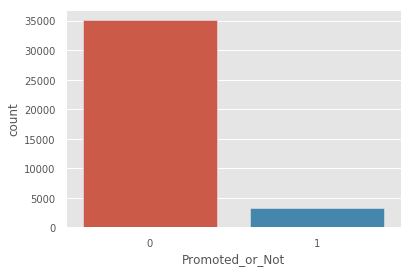

In [62]:
# Now lets check the Promoted_or_Not distributions
sns.countplot("Promoted_or_Not", data=Complete_Variables)

- As we know data is imbalanced and the graph shown above also confirmed it

### Checking for the Percentages of the Imbalance

In [63]:
# now let us check in the number of Percentages 

# Promoted are repersented by 1
Count_Promoted = len(Complete_Variables[Complete_Variables["Promoted_or_Not"] == 1])
# Not Promoted by 0
Count_Not_Promoted = len(Complete_Variables[Complete_Variables["Promoted_or_Not"] == 0])

Percentage_of_Promoted = Count_Promoted/(Count_Promoted + Count_Not_Promoted)
print("Percentage of Promoted is: ", Percentage_of_Promoted * 100)

Percentage_of_Not_Promoted = Count_Not_Promoted/(Count_Promoted + Count_Not_Promoted)
print("Percentage of Not Promoted is: ", Percentage_of_Not_Promoted * 100)

Percentage of Promoted is:  8.459490499060347
Percentage of Not Promoted is:  91.54050950093965


* Hence, in data there is only 8.46% that are promoted while 91.54 are not promoted
* So now we have to solve the imbalance class problem by resampling the data, using SMOTE

# Creating the Target and Predictor Variables

In [64]:
Y_Data = Complete_Variables['Promoted_or_Not']
X_Data = Complete_Variables.drop('Promoted_or_Not',axis=1)

In [65]:
X_Data.shape, Y_Data.shape

((38312, 47), (38312,))

### Normalizing the Resampled_Train and Splitted Test Data

In [66]:
sc = StandardScaler()

X_Data = sc.fit_transform(X_Data)

# Parameter and Hyperparameter Tuning Using RandomSearchCV

In [ ]:
# using only XGBoosting Classifier
pipeline_v1 = Pipeline([('Scaling', StandardScaler()), 
                     ('boosting', XGBClassifier())])

# Getting Parameters for the grid

param_grid_v1 = {
    'boosting__learning_rate':[0.0001, 0.001, 0.01, 0.1],
    'boosting__n_estimators':[100, 150, 200, 250],
    #'boosting__max_depth':[3, 5, 8, 12], 
    'boosting__objective':['binary:logistic'], 
    'boosting__reg_alpha':[0.001, 0.01, 0.1], 
    'boosting__random_state':[0, 20, 30, 42], 
    'boosting__eval_metric':['auc', 'error','logloss','error@0.6'],
    'boosting__booster':['gbtree', 'gblinear', 'dart'],
    'boosting__base_score':[0.1, 0.5, 0.8, 0.9],
    'boosting__gamma':[0.0, 0.3, 0.5, 1.0, 2.0, 5.0 ]
}

In [ ]:
Random = RandomizedSearchCV(pipeline_v1, cv=5, param_distributions=param_grid_v1)
Random.fit(X_Data, Y_Data)

In [ ]:
means = Random.cv_results_['mean_test_score']
stds = Random.cv_results_['std_test_score']
params = Random.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (Random.best_score_, Random.best_params_))

In [ ]:
#Random.get_params()

In [ ]:
# Using Logistic Regression

pipeline_v2 = Pipeline([('Scaling', StandardScaler()), 
                        ('logistic', LogisticRegression())])

param_grid_v2 = {
    'logistic__random_state':[0, 20, 30, 42],
    'logistic__penalty':['none','l2'],
    'logistic__solver':['sag', 'saga'],
    #'logistic__max_iter':[10, 50, 100, 150],
    #'logistic__l1_ratio':[0, 0.2, 0.3, 0.5, 0.8, 1],
    'logistic__multi_class':['ovr', 'multinomial', 'auto']
}

In [ ]:
Random_v2 = RandomizedSearchCV(pipeline_v2, cv=5, param_distributions=param_grid_v2)
Random_v2.fit(X_Data, Y_Data)

In [ ]:
means = Random_v2.cv_results_['mean_test_score']
stds = Random_v2.cv_results_['std_test_score']
params = Random_v2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (Random_v2.best_score_, Random_v2.best_params_))

In [ ]:
 # Using Support Vector Machine

pipeline_v3 = Pipeline([('Scaling', StandardScaler()), 
                        ('svc', SVC(cache_size=7000))])

param_grid_v3 = {
    'svc__random_state':[0, 20, 30, 42],
    'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__gamma':['scale', 'auto'],
    'svc__C':[1e5, 1e3, 1],
    'svc__max_iter':[10, 50, 100, 150],
    'svc__tol':[1e-3, 1e5, 1e8, 1e-7, 1e-8, 1e-10],
    'svc__decision_function_shape' : ['ovo', 'ovr'],
}

In [ ]:
Random_v3 = RandomizedSearchCV(pipeline_v3, cv=5, param_distributions=param_grid_v3)
Random_v3.fit(X_Data, Y_Data)

In [ ]:
means = Random_v3.cv_results_['mean_test_score']
stds = Random_v3.cv_results_['std_test_score']
params = Random_v3.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (Random_v3.best_score_, Random_v3.best_params_))

In [ ]:
 # Using Random Forest Classifier

pipeline_v4 = Pipeline([('Scaling', StandardScaler()), 
                        ('randomforest', RandomForestClassifier())])

param_grid_v4 = {
    'randomforest__random_state':[0, 20, 30, 42],
    'randomforest__criterion':['gini', 'entropy'],
    'randomforest__oob_score':['False', 'True'],
    'randomforest__n_estimators':[100, 150, 200, 250],
    'randomforest__max_depth':[5, 10, 2, 20],
    'randomforest__max_features' : ['auto', 'sqrt', 'log2'],
}

In [ ]:
Random_v4 = RandomizedSearchCV(pipeline_v4, cv=5, param_distributions=param_grid_v4)
Random_v4.fit(X_Data, Y_Data)

In [ ]:
means = Random_v4.cv_results_['mean_test_score']
stds = Random_v4.cv_results_['std_test_score']
params = Random_v4.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (Random_v4.best_score_, Random_v4.best_params_))

In [ ]:
 # Using Decision Tree Classifier

pipeline_v5 = Pipeline([('Scaling', StandardScaler()), 
                        ('decisionTree', DecisionTreeClassifier(presort=True))])

param_grid_v5 = {
    'decisionTree__random_state':[0, 20, 30, 42],
    'decisionTree__criterion':['gini', 'entropy'],
    'decisionTree__splitter':['best', 'random'],
    'decisionTree__max_depth':[5, 10, 2, 20],
    'decisionTree__max_features' : ['auto', 'sqrt', 'log2'],
}

In [ ]:
Random_v5 = RandomizedSearchCV(pipeline_v5, cv=5, param_distributions=param_grid_v5)
Random_v5.fit(X_Data, Y_Data)

In [ ]:
means = Random_v5.cv_results_['mean_test_score']
stds = Random_v5.cv_results_['std_test_score']
params = Random_v5.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (Random_v5.best_score_, Random_v5.best_params_))

# Main Predictions With Splitted Dataset

## Splitting the Complete Dataset into 80% Train and 20% Test

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_Data, Y_Data, test_size=0.2,
                                               random_state=42)

In [68]:
# Transforming the Test Set using the StandardScaller = sc
#X_test = sc.transform(X_test)

## Resampling the Train Data using SMOTE

In [69]:
X_resampled, Y_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(Y_resampled).items()))

[(0, 28075), (1, 28075)]


In [70]:
Model_feature_columns = Complete_Variables.drop('Promoted_or_Not', axis=1).columns

In [71]:
# Feature Renamaing

Feature_names = ['Trainings_Attended', 'Last_performance_score', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'Age_of_Employee',
       'Number_of_Years_Worked', 'Division_Business Finance Operations',
       'Division_Commercial Sales and Marketing',
       'Division_Customer Support and Field Operations',
       'Division_Information Technology and Solution Support',
       'Division_Information and Strategy', 'Division_People/HR Management',
       'Division_Regulatory and Legal services',
       'Division_Research and Innovation', 'Division_Sourcing and Purchasing',
       'Qualification_First Degree or HND', 'Qualification_MSc, MBA and PhD',
       'Qualification_Non-University Education', 'Gender_Female',
       'Gender_Male', 'Channel_of_Recruitment_Agency and others',
       'Channel_of_Recruitment_Direct Internal process',
       'Channel_of_Recruitment_Referral and Special candidates',
       'Foreign_schooled_No', 'Foreign_schooled_Yes',
       'Past_Disciplinary_Action_No', 'Past_Disciplinary_Action_Yes',
       'Previous_IntraDepartmental_Movement_No',
       'Previous_IntraDepartmental_Movement_Yes', 'No_of_previous_employers_0',
       'No_of_previous_employers_1', 'No_of_previous_employers_2',
       'No_of_previous_employers_3', 'No_of_previous_employers_4',
       'No_of_previous_employers_5', 'No_of_previous_employers_More than 5',
       'Started_work_at_the_company_No', 'Started_work_at_the_company_Yes',
       'Employee_Attitude_Devoted', 'Employee_Attitude_Not Devoted',
       'Performance_Ranking_Average', 'Performance_Ranking_High',
       'Performance_Ranking_Low',
       'Trainings_and_Awards_Few_Trainings_with_Awards',
       'Trainings_and_Awards_Few_Trainings_without_Award',
       'Trainings_and_Awards_More_Trainings_without_Award']

### Parameter and Hyperparameter tuning for Logistic Regression

- We tune all paramters and hyperparameters and print out the best
- and implement the best results on the Logistic Regression Model

In [73]:
# Using Logistic Regression

pipeline_lr = Pipeline([('Scaling', StandardScaler()), 
                        ('logistic', LogisticRegression())])

param_grid_lr = {
    'logistic__random_state':[0, 20, 30, 42],
    'logistic__penalty':['l2'],
    'logistic__solver':['sag', 'saga', 'liblinear'],
    #'logistic__max_iter':[10, 50, 100, 150],
    #'logistic__l1_ratio':[0, 0.2, 0.3, 0.5, 0.8, 1],
    'logistic__tol':[1e-3, 1e5, 1e8, 1e-7, 1e-8, 1e-10],
    'logistic__multi_class':['ovr', 'auto']
}

In [ ]:
Random_lr = RandomizedSearchCV(pipeline_lr, cv=5, param_distributions=param_grid_lr)
Random_lr.fit(X_resampled, Y_resampled)

In [ ]:
means = Random_lr.cv_results_['mean_test_score']
stds = Random_lr.cv_results_['std_test_score']
params = Random_lr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (Random_lr.best_score_, Random_lr.best_params_))

### Implementing Best Results on Binary Logistic Regression Model

In [72]:
lr = LogisticRegression(random_state=42, solver ='liblinear', tol=1e-7,
                       multi_class='ovr')
lr = lr.fit(X_resampled, Y_resampled)
pred_y = lr.predict(X_test)

# How is our Accuracy level?
print(np.unique(pred_y))
print("Accuracy: %.2f%%" % accuracy_score(y_test, pred_y))
print(classification_report(y_test, pred_y))

# Confusion Matrix
conf_mat = confusion_matrix(y_true = y_test, y_pred = pred_y)
print('Confusion matrix:\n', conf_mat)

# Cross Validation Score
print('Cross_Val_Score :', cross_val_score(lr, X_resampled, Y_resampled, cv = 5))

[0 1]
Accuracy: 0.77%
              precision    recall  f1-score   support

           0       0.97      0.76      0.86      6996
           1       0.24      0.79      0.37       667

    accuracy                           0.77      7663
   macro avg       0.61      0.78      0.61      7663
weighted avg       0.91      0.77      0.81      7663

Confusion matrix:
 [[5335 1661]
 [ 139  528]]
Cross_Val_Score : [0.79715049 0.80249332 0.80614426 0.8048976  0.80952805]


### Assigning the Classification report and Accuracy report

In [73]:
lr_accuracy = accuracy_score(y_test, pred_y)
lr_precision = precision_score(y_test, pred_y, average='macro')
lr_f1_score = f1_score(y_test, pred_y, average='macro')
lr_recall = recall_score(y_test, pred_y, average='macro')

### Feature Importance

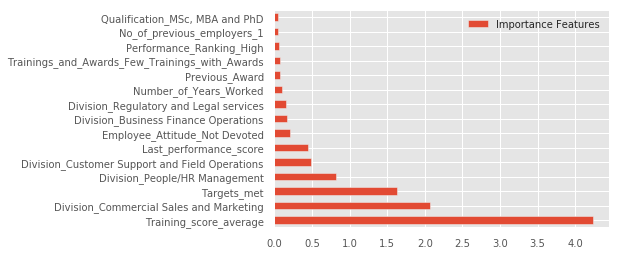

In [76]:
feat_importance = pd.DataFrame(lr.coef_[0], index = Feature_names, 
                               columns=['Importance Features'])
feat_importance.nlargest(15, columns=['Importance Features']).plot(kind='barh')

In [77]:
lr_important_feat =feat_importance
lr_important_feat.columns=['Important Features']

In [79]:
lr_important_feat.sort_values(by='Important Features', ascending=False)

Important Features
Training_score_average                                        4.236781
Division_Commercial Sales and Marketing                       2.062742
Targets_met                                                   1.626817
Division_People/HR Management                                 0.815134
Division_Customer Support and Field Operations                0.492654
Last_performance_score                                        0.453286
Employee_Attitude_Not Devoted                                 0.206428
Division_Business Finance Operations                          0.172862
Division_Regulatory and Legal services                        0.159713
Number_of_Years_Worked                                        0.101756
Previous_Award                                                0.079034
Trainings_and_Awards_Few_Trainings_with_Awards                0.079034
Performance_Ranking_High                                      0.057750
No_of_previous_employers_1                                    0.050766
Qualification_MSc, MBA and PhD                                0.047809
Previous_IntraDepartmental_Movement_No                        0.039031
No_of_previous_employers_4                                    0.037018
Trainings_and_Awards_More_Trainings_without_Award             0.024773
Foreign_schooled_Yes                                          0.020798
Channel_of_Recruitment_Agency and others                      0.020789
Past_Disciplinary_Action_Yes                                  0.013824
Performance_Ranking_Low                                       0.008999
Started_work_at_the_company_Yes                               0.003233
No_of_previous_employers_0                                    0.003233
Gender_Female                                                 0.002997
Gender_Male                                                  -0.002997
Started_work_at_the_company_No                               -0.003233
Channel_of_Recruitment_Referral and Special can...           -0.003378
No_of_previous_employers_More than 5                         -0.011192
Past_Disciplinary_Action_No                                  -0.013824
Channel_of_Recruitment_Direct Internal process               -0.019926
Foreign_schooled_No                                          -0.020798
Qualification_Non-University Education                       -0.024958
No_of_previous_employers_3                                   -0.038789
Previous_IntraDepartmental_Movement_Yes                      -0.039031
Qualification_First Degree or HND                            -0.040262
No_of_previous_employers_2                                   -0.057418
Performance_Ranking_Average                                  -0.068036
No_of_previous_employers_5                                   -0.079321
Trainings_and_Awards_Few_Trainings_without_Award             -0.082691
Trainings_Attended                                           -0.156910
Employee_Attitude_Devoted                                    -0.206428
Age_of_Employee                                              -0.331372
Division_Sourcing and Purchasing                             -0.637987
Division_Research and Innovation                             -0.910374
Division_Information Technology and Solution Su...           -1.510204
Division_Information and Strategy                            -1.797195

### Parameter and Hyperparameter tunning for Support Vector Classifier Model

In [ ]:
 # Using Support Vector Machine

pipeline_svm = Pipeline([('Scaling', StandardScaler()), 
                        ('svc', SVC(cache_size=7000, probability=True))])

param_grid_svm = {
    'svc__random_state':[0, 20, 30, 42],
    'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__gamma':['scale', 'auto'],
    'svc__C':[1e5, 1e3, 1e-1,1e1],
    #'svc__max_iter':[10, 50, 100, 150],
    'svc__tol':[1e-3, 1e5, 1e8, 1e-7, 1e-8, 1e-10],
    'svc__decision_function_shape' : ['ovo', 'ovr'],
}

In [ ]:
Random_svm = RandomizedSearchCV(pipeline_svm, cv=5, param_distributions=param_grid_svm)
Random_svm.fit(X_resampled, Y_resampled)

In [ ]:
means = Random_svm.cv_results_['mean_test_score']
stds = Random_svm.cv_results_['std_test_score']
params = Random_svm.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (Random_svm.best_score_, Random_svm.best_params_))

### Implementing the Best Results on Support Vector Classifier 

In [ ]:
# Building a basic SVM model using the SVC method
supportvector = SVC(random_state=42, decision_function_shape='ovr', probability=True, 
                    gamma='auto', kernel='linear', C=0.1)
supportvector.fit(X_resampled, Y_resampled)
s_predict = supportvector.predict(X_test)

# How is our Accuracy Level?
print(np.unique(s_predict))
print("Accuracy: %.2f%%" % accuracy_score(y_test, s_predict))
print(classification_report(y_test , s_predict))

# Confusion Matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=s_predict)
print('Confusion matrix:\n', conf_mat)

In [ ]:
# Cross Validation Score
print('Cross_Val_Score :',cross_val_score(supportvector,X_resampled,Y_resampled, cv=5))

### Assigning the Classification Report and Accuracy Score

In [ ]:
svc_accuracy = accuracy_score(y_test, s_predict)
svc_precision = precision_score(y_test, s_predict, average='macro')
svc_f1_score = f1_score(y_test, s_predict, average='macro')
svc_recall = recall_score(y_test, s_predict, average='macro')

### Plotting Feature Importance

In [ ]:
feat_importance = pd.Series(abs(supportvector.coef_[0]), index = Feature_names)
feat_importance.nlargest(10).plot(kind='barh')

In [ ]:
svm_important_feat = feat_importance
svm_important_feat.columns = ['Important Features']
svm_important_feat.sort_values(by='Important Features', ascending=False)

### Parameter and Hyperparameter tunning for Random Forest Classifier Model

In [ ]:
 # Using Random Forest Classifier

pipeline_rfc = Pipeline([('Scaling', StandardScaler()), 
                        ('randomforest', RandomForestClassifier())])

param_grid_rfc = {
    'randomforest__random_state':[0, 20, 30, 42],
    'randomforest__criterion':['gini', 'entropy'],
    'randomforest__oob_score':['False', 'True'],
    'randomforest__n_estimators':[100, 150, 200, 250],
    'randomforest__max_depth':[5, 10, 2, 20],
    'randomforest__max_features' : ['auto', 'sqrt', 'log2'],
}

In [ ]:
Random_rfc = RandomizedSearchCV(pipeline_rfc, cv=5, param_distributions=param_grid_rfc)
Random_rfc.fit(X_resampled, Y_resampled)

In [ ]:
means = Random_rfc.cv_results_['mean_test_score']
stds = Random_rfc.cv_results_['std_test_score']
params = Random_rfc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (Random_rfc.best_score_, Random_rfc.best_params_))

### Implementing the Best Results on Random Forest Classifier

In [80]:
# Building a basic random forest using the RandomForestClassifier method
randomforest = RandomForestClassifier(random_state=42, n_estimators=100, max_features='sqrt',
                                      criterion= 'gini')
randomforest.fit(X_resampled, Y_resampled)
rfc_predict = randomforest.predict(X_test)

# What is our Accuracy Level?
# Is our model still predicting only one class?
print('The model is predicting both classes :', np.unique(rfc_predict))  
print("Accuracy: %.2f%%" % accuracy_score(y_test, rfc_predict))
print(classification_report(y_test, rfc_predict))

# Confusion Matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=rfc_predict)
print('Confusion matrix:\n', conf_mat)

# Cross Validation Score
print('Cross_Val_Score :', cross_val_score(randomforest,X_resampled,Y_resampled, cv=5))

The model is predicting both classes : [0 1]
Accuracy: 0.91%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      6996
           1       0.46      0.31      0.37       667

    accuracy                           0.91      7663
   macro avg       0.70      0.64      0.66      7663
weighted avg       0.90      0.91      0.90      7663

Confusion matrix:
 [[6755  241]
 [ 459  208]]
Cross_Val_Score : [0.8856634  0.9779163  0.97809439 0.97577916 0.97871772]


### Assigning the Accuracy Score and Classification Report of Random Forest

In [81]:
rfc_accuracy = accuracy_score(y_test, rfc_predict)
rfc_precision = precision_score(y_test, rfc_predict, average='macro')
rfc_f1_score = f1_score(y_test, rfc_predict, average='macro')
rfc_recall = recall_score(y_test, rfc_predict, average='macro')

### Plotting Feature Importance

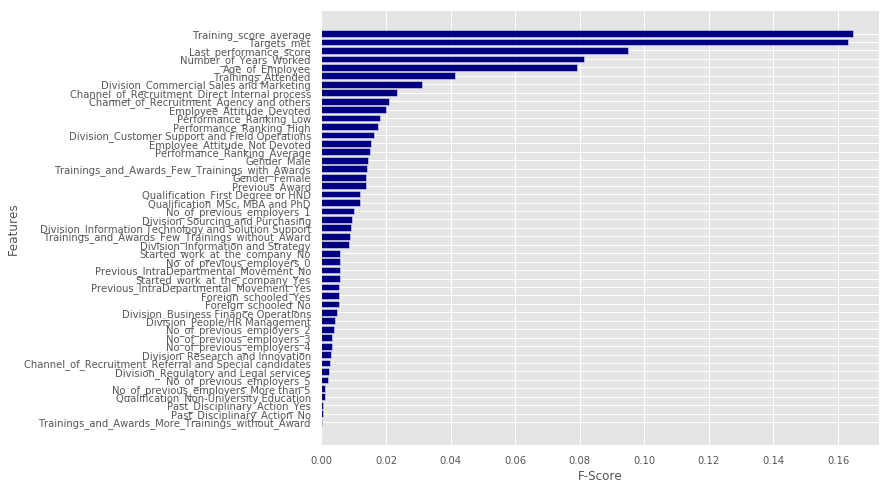

In [103]:
Features = Feature_names

Feature_importance = randomforest.feature_importances_
checking_indices = np.argsort(Feature_importance)

# Plotting
plt.figure(figsize=(10,8))
plt.barh(range(len(checking_indices)), Feature_importance[checking_indices],
        color = 'navy', align = 'center')
plt.yticks(range(len(checking_indices)), [Features[i] for i in checking_indices])
plt.xlabel('F-Score')
plt.ylabel('Features')

plt.show()

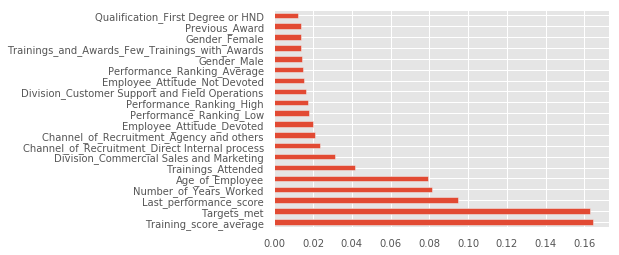

In [83]:
feat_importance = pd.Series(randomforest.feature_importances_, index = Feature_names)
feat_importance.nlargest(20).plot(kind='barh')

### Parameter and Hyperparameter tunning for Decision Tree Classifier Model

In [ ]:
 # Using Decision Tree Classifier

pipeline_dtc = Pipeline([('Scaling', StandardScaler()), 
                        ('decisionTree', DecisionTreeClassifier(presort=True))])

param_grid_dtc = {
    'decisionTree__random_state':[0, 20, 30, 42],
    'decisionTree__criterion':['gini', 'entropy'],
    'decisionTree__splitter':['best', 'random'],
    'decisionTree__max_depth':[5, 10, 2, 20],
    'decisionTree__max_features' : ['auto', 'sqrt', 'log2'],
}

In [ ]:
Random_dtc = RandomizedSearchCV(pipeline_dtc, cv=5, param_distributions=param_grid_dtc)
Random_dtc.fit(X_resampled, Y_resampled)

In [ ]:
means = Random_dtc.cv_results_['mean_test_score']
stds = Random_dtc.cv_results_['std_test_score']
params = Random_dtc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (Random_dtc.best_score_, Random_dtc.best_params_))

### Implementing the Best Results on Basic Decision Tree Classifier

In [84]:
# Implementing a basic decision tree using DecisionTreeClassifier method
decisionTree = DecisionTreeClassifier(random_state=42,splitter='best',
                                      criterion='gini', max_features='log2')
decisionTree = decisionTree.fit(X_resampled, Y_resampled)
dtc_predict = decisionTree.predict(X_test)

# What is our Accuracy Level?
print(np.unique(dtc_predict))
print("Accuracy: %.2f%%" % accuracy_score(y_test, dtc_predict))
print(classification_report(y_test, dtc_predict))

# Confusion Matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=dtc_predict)
print('Confusion matrix:\n', conf_mat)

# Cross Validation Score
print('Cross_Val_Score :', cross_val_score(decisionTree,X_resampled,Y_resampled, cv=5))

[0 1]
Accuracy: 0.86%
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6996
           1       0.26      0.32      0.28       667

    accuracy                           0.86      7663
   macro avg       0.60      0.62      0.60      7663
weighted avg       0.87      0.86      0.87      7663

Confusion matrix:
 [[6385  611]
 [ 455  212]]
Cross_Val_Score : [0.84060552 0.93829029 0.93143366 0.92689225 0.93072128]


#### Assigning the Accuracy and Classification Report of Decision Tree

In [85]:
dtc_accuracy = accuracy_score(y_test, dtc_predict)
dtc_precision = precision_score(y_test, dtc_predict, average='macro')
dtc_f1_score = f1_score(y_test, dtc_predict, average='macro')
dtc_recall = recall_score(y_test, dtc_predict, average='macro')

### Plotting Feature Importance

Text(0.5, 0, 'F-Score')

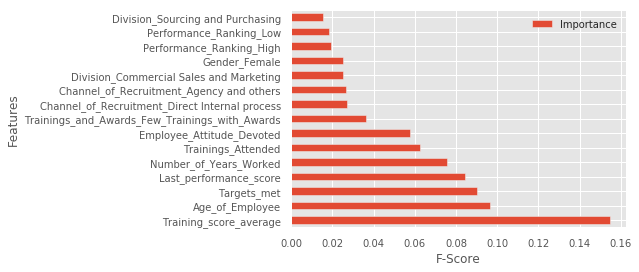

In [86]:
feat_importance = pd.DataFrame(decisionTree.feature_importances_, index = Feature_names,
                              columns=['Importance']).sort_values('Importance', ascending=True)
feat_importance.nlargest(15, columns=['Importance']).plot(kind='barh')
plt.ylabel('Features')
plt.xlabel('F-Score')

In [ ]:
dtc_feature_imp = pd.DataFrame(dtc.feature_importances_,columns)
dtc_feature_imp.sort_values(by='Importance', ascending=False)

### Parameter and Hyperparameter tunning for XGBoot Classifier Model

In [ ]:
# using only XGBoosting Classifier without PCA
pipeline_xgb = Pipeline([('Scaling', StandardScaler()), 
                     ('boosting', XGBClassifier())])

# Getting Parameters for the grid

param_grid_xgb = {
    'boosting__learning_rate':[0.0001, 0.001, 0.01, 0.1],
    'boosting__n_estimators':[100, 150, 200, 250],
    'boosting__max_depth':[3, 5, 8, 12], 
    'boosting__objective':['binary:logistic'], 
    'boosting__reg_alpha':[0.001, 0.01, 0.1], 
    'boosting__random_state':[0, 20, 30, 42], 
    'boosting__eval_metric':['auc', 'error','logloss','error@0.6'],
    'boosting__booster':['gbtree', 'gblinear', 'dart'],
    'boosting__base_score':[0.1, 0.5, 0.8, 0.9],
    'boosting__gamma':[0.0, 0.3, 0.5, 1.0, 2.0, 5.0 ],
    'boosting__max_features':['auto', 'sqrt', 'log2']
}

In [ ]:
Random_xgb = RandomizedSearchCV(pipeline_xgb, cv=5, param_distributions=param_grid_xgb)
Random_xgb.fit(X_resampled, Y_resampled)

In [ ]:
means = Random_dtc.cv_results_['mean_test_score']
stds = Random_dtc.cv_results_['std_test_score']
params = Random_dtc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (Random_xgb.best_score_, Random_xgb.best_params_))

### Implementing the Best Results on Xgboost Classifier Model

In [87]:
# fit XgBoost model on training data
xgb_model =XGBClassifier(objective="binary:logistic",reg_alpha=0.001,base_score=0.1,
                          random_state=30, learning_rate=0.1, n_estimators=250, gamma=0.3,
                          max_features='sqrt', eval_metric=["auc", 'logloss', 'error'], 
                         booster='gbtree')
                          

xgb_model.fit(X_resampled, Y_resampled, eval_set=[(X_resampled, Y_resampled),
                                                  (X_test, y_test.values)], verbose=False)

# make predictions for test data
xgb_predict = xgb_model.predict(X_test)

In [88]:
# evaluate predictions and Printing the Accuracy Level
print(np.unique(xgb_predict))
accuracy = accuracy_score(y_test, xgb_predict)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
classification = classification_report(y_test, xgb_predict)
print(classification)

# Confusion Matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=xgb_predict)
print('Confusion matrix:\n', conf_mat)

[0 1]
Accuracy: 92.90%
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      6996
           1       0.72      0.30      0.43       667

    accuracy                           0.93      7663
   macro avg       0.83      0.65      0.69      7663
weighted avg       0.92      0.93      0.92      7663

Confusion matrix:
 [[6916   80]
 [ 464  203]]


In [89]:
# Cross Validation Score
print('Cross_Val_Score :', cross_val_score(xgb_model, X_resampled,Y_resampled, cv=5))

Cross_Val_Score : [0.82181656 0.98619768 0.98361532 0.98317008 0.98459484]


In [ ]:
print("best score: {0},\n best iteration: {1},\n best ntree limit {2}".format(xgb_model.best_score, 
      xgb_model.best_iteration, xgb_model.best_ntree_limit))

In [90]:
xgb_accuracy = accuracy_score(y_test, xgb_predict)
xgb_precision = precision_score(y_test, xgb_predict, average='macro')
xgb_f1_score = f1_score(y_test, xgb_predict, average='macro')
xgb_recall = recall_score(y_test, xgb_predict, average='macro')

### Fit the model using Importance as the Threshold

In [ ]:
from sklearn.feature_selection import SelectFromModel
from numpy import sort

In [ ]:
xgb_model.get_booster().feature_names = Feature_names
thresholds = sort(xgb_model.feature_importances_)
for thresh in thresholds:
    # Select features using threshold
    Selection = SelectFromModel(xgb_model, threshold = thresh, prefit=True)
    select_X_resampled = Selection.transform(X_resampled)
    
    # train model
    model_selection = XGBClassifier(objective="binary:logistic",reg_alpha=0.1,max_depth=12,
                                    base_score=0.9,random_state=42,learning_rate=0.1,gamma=0.05,
                                    n_estimators=1000,max_features='auto', 
                                    eval_metric=["auc", 'logloss', 'error'], booster='gbtree')
    model_selection.fit(select_X_resampled, Y_resampled)
    
    # model Evaluation
    select_X_test = Selection.transform(X_test)
    xgb_predict = model_selection.predict(select_X_test)
    predictions = [round(value) for value in xgb_predict]
    F1_Score = f1_score(y_test, predictions, average = 'macro')
    Accuracy_Score = accuracy_score(y_test, predictions)
    print('Thresh=%.3f, n=%d, F1-Score: %.3f%%, Accuracy: %.3f%%'%(thresh,
                                                                   select_X_resampled.shape[1], 
                                                                   F1_Score*100.0,
                                                                   Accuracy_Score*100.0))

### Important Features

In [102]:
xgb_model.get_booster().feature_names = Feature_names

Import_Features = pd.DataFrame(xgb_model.feature_importances_,columns = ['importance'])
Import_Features.sort_values(by='importance', ascending=True)

importance
46    0.000000
25    0.000000
26    0.000000
27    0.000000
29    0.000000
33    0.000000
20    0.000000
34    0.000000
37    0.000000
38    0.000000
40    0.000000
44    0.000000
36    0.000000
18    0.000000
13    0.000329
32    0.000900
39    0.001417
42    0.001664
23    0.002095
45    0.002525
35    0.004528
10    0.005326
30    0.009364
22    0.009738
14    0.009848
17    0.009862
7     0.010600
12    0.010712
24    0.014896
16    0.015436
43    0.016222
5     0.016548
11    0.016660
28    0.016970
31    0.018656
15    0.023440
9     0.037139
19    0.041259
6     0.041495
0     0.047009
4     0.055985
8     0.056533
3     0.059783
41    0.074500
1     0.106356
21    0.118350
2     0.143853

### Plotting of the Important Features

[Text(0, 0, 'Trainings_Attended'),
 Text(0, 0, 'Last_performance_score'),
 Text(0, 0, 'Targets_met'),
 Text(0, 0, 'Previous_Award'),
 Text(0, 0, 'Training_score_average'),
 Text(0, 0, 'Age_of_Employee'),
 Text(0, 0, 'Number_of_Years_Worked'),
 Text(0, 0, 'Division_Business Finance Operations'),
 Text(0, 0, 'Division_Commercial Sales and Marketing'),
 Text(0, 0, 'Division_Customer Support and Field Operations'),
 Text(0, 0, 'Division_Information Technology and Solution Support'),
 Text(0, 0, 'Division_Information and Strategy'),
 Text(0, 0, 'Division_People/HR Management'),
 Text(0, 0, 'Division_Regulatory and Legal services'),
 Text(0, 0, 'Division_Research and Innovation')]

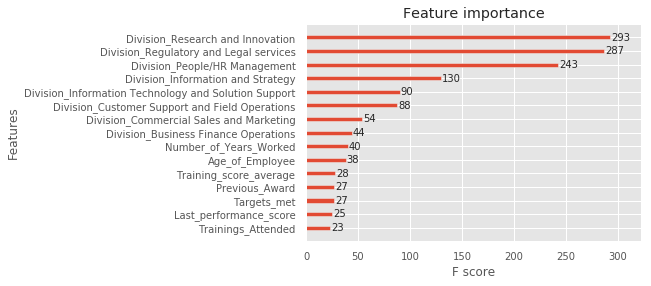

In [91]:
# Reassigning the feature names to the array 
xgb_model.get_booster().feature_names = Feature_names

# Plotting the important features
xgb.plot_importance(xgb_model,max_num_features= 15, height=0.3).set_yticklabels(Feature_names)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
#xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
#xgb.to_graphviz(xgb_model, num_trees= xgb_model.best_iteration)

## Summary of Model Reports

In [92]:
Summary=[['Binary Logistic Regression',lr_accuracy,lr_precision,lr_recall,lr_f1_score],
      ['Decision Tree Classifier',dtc_accuracy,dtc_precision,dtc_recall,dtc_f1_score],
      ['Random Forest Classifier',rfc_accuracy,rfc_precision,rfc_recall,rfc_f1_score],
      ['Support Vector Machine Classifier',svc_accuracy,svc_precision,svc_recall,svc_f1_score],
      ['xgBoost Classifier',xgb_accuracy,xgb_precision,xgb_recall,xgb_f1_score] 
]

Performance_Summary=pd.DataFrame(Summary)

Performance_Summary.columns=['Classifier','Accuracy','Precision','Recall','F1-Score']

In [93]:
Performance_Summary.sort_values(by='F1-Score', ascending=False)

Classifier  Accuracy  Precision    Recall  F1-Score
4                 xgBoost Classifier  0.929010   0.827221  0.646456  0.694764
2           Random Forest Classifier  0.908652   0.699813  0.638698  0.661749
0         Binary Logistic Regression  0.765627   0.607932  0.776699  0.612934
1           Decision Tree Classifier  0.860890   0.595537  0.615253  0.603759
3  Support Vector Machine Classifier  0.721780   0.605868  0.802191  0.591194

## ROC Curve for the Considered Models

In [94]:
# Computing ROC curve and ROC area for all Models
# For Logistic Regression
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, pred_y)
lr_roc_auc = auc(lr_fpr, lr_tpr)

# For Support Vector Machine
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, s_predict)
svm_roc_auc = auc(svm_fpr, svm_tpr)

# For Random Forest Classifier
rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(y_test, rfc_predict)
rfc_roc_auc = auc(rfc_fpr, rfc_tpr)

# For Decision Tree Classifier
dtc_fpr, dtc_tpr, dtc_thresholds = roc_curve(y_test, dtc_predict)
dtc_roc_auc = auc(dtc_fpr, dtc_tpr)

# For XGBoost Classifier
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_predict)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

In [101]:
# The ROC_auc Score
ROC_Score = roc_auc_score(y_test, s_predict)
ROC_Score

0.8021907785386895

In [96]:
#from itertools import cycle

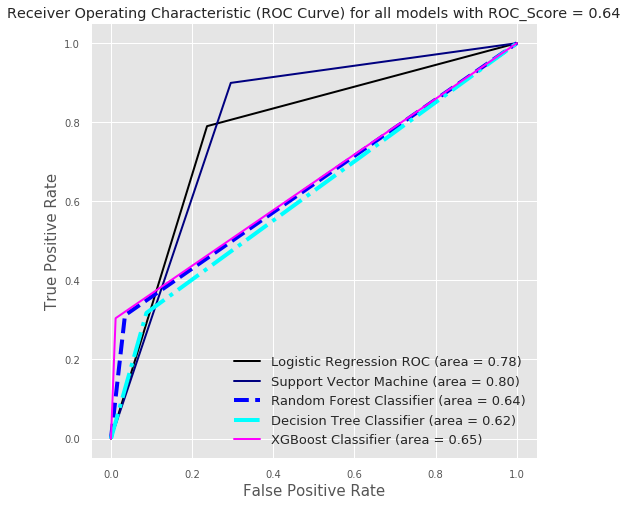

In [97]:
plt.figure(figsize=(8,8))
sns.lineplot(lr_fpr, lr_tpr, color = 'black',
         label='Logistic Regression ROC (area = %0.2f)'%lr_roc_auc, linewidth=2,linestyle='dashed')
sns.lineplot(svm_fpr,svm_tpr, color = 'navy', 
         label='Support Vector Machine (area = %0.2f)'%svm_roc_auc, linewidth=2,linestyle=':')
plt.plot(rfc_fpr,rfc_tpr, color = 'blue', 
         label='Random Forest Classifier (area = %0.2f)'%rfc_roc_auc, linewidth=4,linestyle='--')
plt.plot(dtc_fpr,dtc_tpr, color = 'cyan', 
         label='Decision Tree Classifier (area = %0.2f)'%dtc_roc_auc, linewidth=4,linestyle='-.')
sns.lineplot(xgb_fpr,xgb_tpr, color = 'magenta', 
         label='XGBoost Classifier (area = %0.2f)'%xgb_roc_auc, linewidth=2, linestyle='dotted')
plt.legend(prop = {'size':13},loc='best')
plt.title('Receiver Operating Characteristic (ROC Curve) for all models with ROC_Score = %0.2f'% ROC_Score)
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.show()

## VOTING ENSEMBLE FOR THE FIVE CLASSIFICATION

In [98]:
from sklearn.ensemble import VotingClassifier

In [99]:
## Now we create sub models
estimators = []

model_1 = lr
estimators.append(('log_reg', model_1))

model_2 = decisionTree
estimators.append(('decision_Tree', model_2))

model_3 = randomforest
estimators.append(('random_forest', model_3))

model_4 = supportvector
estimators.append(('support_vector', model_4))

model_5 = xgb_model
estimators.append(('xgb_model', model_5))

In [104]:
# Creating the ensemble model with the parameters, "Hard, Soft, and Weighted"

Ensemble_Hard = VotingClassifier(estimators, voting='hard')
Ensemble_Soft = VotingClassifier(estimators, voting= 'soft')
Ensemble_Weighted = VotingClassifier(estimators, voting='hard', weights=[2,1,2,2,3])

In [ ]:
# Printing the Results

Results_Hard = cross_val_score(Ensemble_Hard, X_resampled,Y_resampled, cv=5)
print('Mean of Ensemble_Hard :', Results_Hard.mean())
print('Cross Validation Score_Hard : ', Results_Hard)

Results_Soft = cross_val_score(Ensemble_Soft, X_resampled,Y_resampled, cv=5)
print('Mean of Ensemble_Soft :', Results_Soft.mean())
print('Cross Validation Score_Soft: ', Results_Soft)

Results_Weighted = cross_val_score(Ensemble_Weighted, X_resampled,Y_resampled, cv=5)
print('Mean of Ensemble_Weighted :', Results_Weighted.mean())
print('Cross Validation Score_Weighted: ', Results_Weighted)

### Comparing the SIX Models Using their F1_Score

In [ ]:
Indicies = ['Logistic Regression', 'Support Vector', 'Decision Tree', 'Random Forest',
            'XGBoost','Hard Voting Ensemble','Soft Voting Ensemble','Weighted Voting Ensemble']
for (classifier, index) in zip([lr, supportvector, decisionTree, randomforest, xgb_model,
                                Ensemble_Hard, Ensemble_Soft, Ensemble_Weighted], Indicies):

    scores = cross_val_score(classifier, X_resampled, Y_resampled, cv=5, 
                             scoring=metrics.make_scorer(metrics.scorer.f1_score, 
                                                         average="macro"))
    print("F1_Score: %0.2f  [%s]" 
          % (scores.mean(),  index))

In [ ]:
print(estimators)